In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pytz
from datetime import datetime
import MetaTrader5 as mt5


In [ ]:
from Modules import FinFeatures

symbol = "EURUSD"
timeframe = mt5.TIMEFRAME_M5

timezone  = pytz.timezone("UTC")
date_from = datetime(2024, 9, 1, tzinfo=timezone)
date_to   = datetime(2025, 12, 1, tzinfo=timezone)


Features = FinFeatures.MarketFeatureBuilder(symbol, timeframe, date_from, date_to)
final_data = Features.fetch_MT5_data().save(path='./Data/raw/')

Datetime = pd.to_datetime(final_data.data['time']).dt
period = [Datetime.date, Datetime.isocalendar().year.astype(str)+'-'+Datetime.isocalendar().week.astype(str)]
              
final_data = (Features
                .core_features()
                .level_features(period)
                .target_label()
                .save(path='./Data/processed/')
                )

Data saved as ./Data/raw/EURUSD -- 5 (2024-09-01 - 2025-12-01).csv


## Get Data from MT5

In [ ]:
def fetch_MT5_data(symbol: str, timeframe: int, date_from: datetime, date_to: datetime):

    if not mt5.initialize():
        print(f"initialize() failed, error code = {mt5.last_error()}")
        mt5.shutdown()
    else:

        ranges = [(date_from, date_to)]     # List of intervals
        dfs = []

        max_splits = 5
        # As long as we have a range and the number of divisions does not exceed the allowed limit
        while ranges and max_splits > 0:    
            new_ranges = []
            for start, end in ranges:
                rates = mt5.copy_rates_range(symbol, timeframe, start, end)

                if rates is not None and len(rates) > 0:
                    df = pd.DataFrame(rates)
                    df['time'] = pd.to_datetime(df['time'], unit='s')
                    dfs.append(df)
                else:
                    # If no data is returned, halve the interval
                    mid = start + (end - start) / 2
                    new_ranges.append((start, mid))
                    new_ranges.append((mid, end))

            ranges = new_ranges
            max_splits -= 1

        mt5.shutdown()

        if dfs:
            final_df = pd.concat(dfs).drop_duplicates().sort_values(by="time").reset_index(drop=True)
            temp_date = final_df['time'].dt.date
            final_df.to_csv(f'{symbol} -- {timeframe} ({temp_date[0]} - {temp_date.values[-1]}).csv', index=False)
        else:
            print(f"Failed to fetch data or no data found. Error: {mt5.last_error()}")


symbol = "EURUSD"
timeframe = mt5.TIMEFRAME_M5

timezone  = pytz.timezone("UTC")
date_from = datetime(2023, 10, 1, tzinfo=timezone)
date_to   = datetime(2025, 12, 1, tzinfo=timezone)

fetch_MT5_data(symbol, timeframe, date_from, date_to)

In [ ]:
# -------------------------------------------------------------------------------------------
def fetch_MT5_data(symbol: str, timeframe: int, date_from: datetime, date_to: datetime):
    if not mt5.initialize():
        print(f"initialize() failed, error code = {mt5.last_error()}")
        mt5.shutdown()
    else:
        
        rates = mt5.copy_rates_range(symbol, timeframe, date_from, date_to)
        
        if rates is not None and len(rates) > 0:
            df = pd.DataFrame(rates)
            df['time'] = pd.to_datetime(df['time'], unit='s')
            df.to_csv(f'{symbol} -- {timeframe} ({date_from} - {date_to}).csv'.replace(" 00:00:00+00:00", ""), index=False)
        else:
            print(f"Failed to fetch data or no data found. Error: {mt5.last_error()}")
            
        mt5.shutdown()


symbol = "EURUSD"
timeframe = mt5.TIMEFRAME_M5

timezone  = pytz.timezone("UTC")
date_from = datetime(2024, 10, 1, tzinfo=timezone)
date_to   = datetime(2025, 12, 1, tzinfo=timezone)

fetch_MT5_data(symbol, timeframe, date_from, date_to)

None (-2, 'Terminal: Invalid params')
Failed to fetch data or no data found. Error: (-2, 'Terminal: Invalid params')


In [4]:
mt5.initialize()
tick = mt5.symbol_info_tick("EURUSD")

print("Bid:", tick.bid)
print("Ask:", tick.ask)
print("Last:", tick.last)
print("Volume:", tick.volume)

mt5.shutdown()


Bid: 1.17778
Ask: 1.17795
Last: 0.0
Volume: 0


True

## Core Features

In [2]:
# -------------------------------------------------------------------------------------------
def core_features(df: pd.DataFrame):

    df['return']     = np.log(df['close'] / df['close'].shift(1))       # r_{t}​ = ln (Close_{t} − ​Close_{t-1}​​)
    df['body'  ]     = df['close'] - df['open']                         # body_{t} ​= Close_{t} ​− Open_{t}
    df['range' ]     = df['high' ] - df['low' ]                         # range_{t} ​= High_{t} ​− Low_{t}​
    df['upper_wick'] = df['high' ] - df[['open', 'close']].max(axis=1)  # upper = High − max(Open, Close)
    df['lower_wick'] = df[['open', 'close']].min(axis=1) - df['low']    # lower = min(Open, Close) − Low
    df['ema_20']     = df['close'].ewm(span=20, adjust=False).mean()    # EMA_{t} ​= α⋅Close_{t} ​+ (1−α)EMA_{t} − 1​ , α = 2/(N+1)​
    df['price_ema_ratio'] = df['close'] / df['ema_20']                  # trend_strength = Close/EMA​
    df['volatility_20'  ] = df['return'].rolling(20).std()              # σ{t} ​= sqrt( Var(r_{t−n:t}​) )
    df['volume_norm'] = df['tick_volume'] / df['tick_volume'].rolling(20).mean()   	# vol_norm = V/MA(V)
    
	# Time of Day in a Cycle. ( Sin(time), Cos(time) )
    time_in_minutes = pd.to_datetime(df['time']).dt.hour*60 + pd.to_datetime(df['time']).dt.minute
    time_in_radians = 2 * np.pi * time_in_minutes / 1440
    df['time_sin_cos'] = list(zip(np.round(np.sin(time_in_radians), 3), np.round(np.cos(time_in_radians), 3)))

    return df


data = pd.read_csv("M5 (2024-09-01 -- 2025-12-01).csv")
data = core_features(data)

# k = 5
# df['target'] = (df['close'].shift(-k) > df['close']).astype(int)    # y_{t} ​= 1[Close_{t+k} ​> Close_{t}​]
# df



## Candle image → CNN

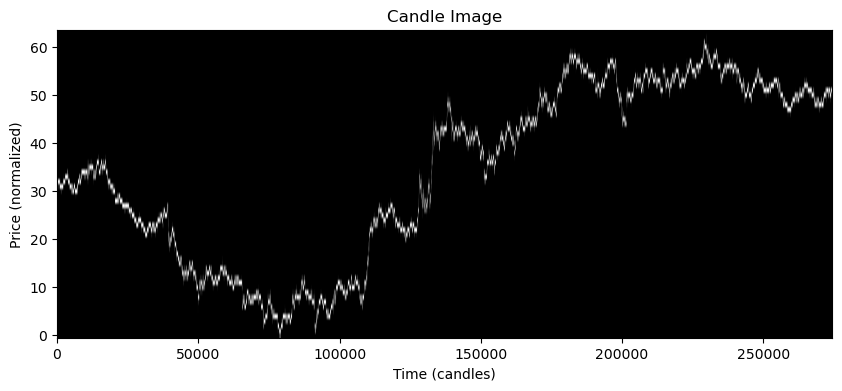

In [ ]:
# -------------------------------------------------------------------------------------------
def candle_image(df_window: pd.DataFrame, height: int=64):
    """
    Generate a binary image of candlesticks within a given time window.

    Each candlestick is represented as a column in the image:
      - Wick is drawn as a vertical line
      - Body is drawn as a filled rectangle

    Parameters
    ----------
    df_window : DataFrame -- containing the columns ['open','high','low','close'] for a time window
    height : int, default=64 -- Image height (number of pixels along the y-axis)

    Returns
    -------
    np.ndarray -- Binary array of shape (height, len(df_window)*3) representing the candlestick visualization.
	"""
    
    img = np.zeros((height, len(df_window)*3))

    norm = normalize_window(df_window)

    for i, row in norm.iterrows():
        x = (i - df_window.index[0]) * 3 + 1

        o, h, l, c = row
        y_o = int(o * (height-1))
        y_c = int(c * (height-1))
        y_h = int(h * (height-1))
        y_l = int(l * (height-1))

        img[y_l:y_h+1, x] = 1							# wick
        img[min(y_o,y_c):max(y_o,y_c)+1, x-1:x+2] = 1	# body

    return img

# p′ = (p−min(low)) / (max(high)−min(low))
def normalize_window(df_window: pd.DataFrame):
    low = df_window['low'].min()
    high = df_window['high'].max()
    return (df_window[['open','high','low','close']] - low) / (high - low)


img = candle_image(df_window=data, height=64)

plt.figure(figsize=(10,4))
plt.imshow(img, cmap='gray', origin='lower', aspect='auto')
plt.title ("Candle Image")
plt.xlabel("Time (candles)")
plt.ylabel("Price (normalized)")
plt.show()


## Level Features

In [ ]:
# -------------------------------------------------------------------------------------------
def level_features(df: pd.DataFrame, period: list[pd.Series], atr_window: int=14, digits: int=2, ema_span :int=12*12):
    """
      Perform three calculations on the DataFrame:
      1. Distance of the candle shadow from the boundaries of the previous period (day or week)
      2. Distance from rounded numbers
      3. EMA and price-to-EMA ratio (trend)
    """

    df = df.copy()

    df['dist_round']        = round_distance (df, digits=digits)
    df[f'trend_{ema_span}'] = add_trend      (df, ema_span=ema_span)
    for p in period: df[f'dist_shadow_prev_{p.name}'] = shadow_distance(df, period=p, atr_window=atr_window)

    return df

def round_distance(df: pd.DataFrame, digits: int=2):
    """
    Calculate the distance of the candle's high and low from the nearest rounded number.

    Parameters:
    ----------
    df : DataFrame containing the columns ['high','low']
    digits : Number of decimal places for rounding (default: 2)

    Output:
    -------
    DataFrame with the following columns:
      - dist_high : distance from high to its nearest rounded number
      - dist_low  : distance from low to its nearest rounded number
      - dist_round: minimum distance between high and low to a rounded number
    """

    df = df.copy()

    factor = 10**digits
    dist_high  = (df['high'] - df['high'].round(digits)) * factor
    dist_low   = (df['low' ] - df['low' ].round(digits)) * factor

    dist_round = np.minimum(dist_high.abs(), dist_low.abs())
    return dist_round

def shadow_distance(df: pd.DataFrame, period: list[pd.Series], atr_window: int=14):
    """
    Calculate the distance of the candle shadow (high/low) from the maximum and minimum of the previous period,
    normalized by ATR.

    Parameters:
    ----------
    df : DataFrame containing the columns ['time','open','high','low','close']
    period : 'day' or 'week' → determines whether the comparison reference is the previous day or the previous week
    atr_window : ATR window length (default: 14)

    Output:
    -------
    DataFrame with columns for the distances and the minimum shadow distance to the previous range
    """

    df = df.copy()

    # Average True Range Calculate
    high_low   = df['high'] - df['low']
    high_close = np.abs(df['high'] - df['close'].shift(1))
    low_close  = np.abs(df['low' ] - df['close'].shift(1))

    tr  = np.maximum(high_low, np.maximum(high_close, low_close))   # TR
    atr = tr.rolling(atr_window).mean()                             # ATR

    # Maximum and minimum period
    agg = df.groupby(period).agg(ref_high=('high','max'), ref_low=('low','min'))
    df  = df.join(agg.shift(1), on=period)              # Add previous period

    # Distance of today's shadow from the boundaries of the previous period
    df['high_to_prev_high'] = (df['high'] - df['ref_high']).abs() / atr
    df['high_to_prev_low' ] = (df['high'] - df['ref_low' ]).abs() / atr
    df['low_to_prev_high' ] = (df['low' ] - df['ref_high']).abs() / atr
    df['low_to_prev_low'  ] = (df['low' ] - df['ref_low' ]).abs() / atr

    # Minimum shadow distance to previous range
    dist_shadow_prev = df[['high_to_prev_high', 'high_to_prev_low', 'low_to_prev_high', 'low_to_prev_low']].min(axis=1)
    return dist_shadow_prev

def add_trend(df: pd.DataFrame, ema_span: int=12*12):
    """
    Calculate EMA and the price-to-EMA ratio as a trend indicator.

    Parameters:
    ----------
    df : DataFrame containing the 'close' column
    ema_span : EMA window length (default: 12*12, approximately 1 hour for 5-minute data)
    col_close : Name of the closing price column (default: 'close')

    Output:
    -------
    DataFrame with the following columns:
      - ema_{ema_span}   : calculated EMA
      - trend_{ema_span} : ratio of close to EMA
    """

    df = df.copy()

    df[f'ema_{ema_span}'] = df['close'].ewm(span=ema_span).mean()
    trend_col = df['close'] / df[f'ema_{ema_span}']

    return trend_col



Datetime = pd.to_datetime(data['time']).dt
period = [Datetime.date, Datetime.isocalendar().year.astype(str)+'-'+Datetime.isocalendar().week.astype(str)]
data = level_features(data, period=period, atr_window=14)
data.to_csv('test.csv', index=False)

## Target

In [ ]:
def target_label(df: pd.DataFrame, 
                 horizon: int=24, 
                 regime_threshold: float=1.0,
                 sl_mult: float=1.0, tp_mult: float=2.0,
                 price_col: str="close", high_col: str="high", low_col: str="low",
                 vol_col: str="volatility_20", direction_col: str="market_regime"):
    
    df = df.copy()

    df["market_regime"] = calc_market_regime(df, horizon+6, regime_threshold, price_col, vol_col)
    df["trade_outcome"] = calc_trade_outcome(df, horizon, sl_mult, tp_mult, direction_col)
    df["MFE_norm"], df["MAE_norm"] = calc_mfe_mae (df, horizon, price_col, high_col, low_col, vol_col)

    return df

def calc_market_regime(df: pd.DataFrame, horizon=30, threshold=1.0, price_col="close", vol_col="volatility_20"):
    """
    Label market regime based on future trend strength.

    Formula:
        trend_strength = log(C[t+H] / C[t]) / volatility[t]

    Parameters
    ----------
    df : DataFrame -- containing price and volatility columns
    horizon : int, default=30 -- Prediction horizon (number of candles ahead to compute future return)
    threshold : float, default=1.0 -- Trend strength threshold for identifying UpTrend or DownTrend
    price_col : str, default="close" -- Name of the closing price column
    vol_col : str, default="volatility_20" -- Name of the volatility column (standard deviation of returns)

    Returns
    -------
    DataFrame -- with a new column:
        - market_regime ∈ {-1, 0, +1}
          -1 → DownTrend
           0 → Range
          +1 → UpTrend
    """

    df = df.copy()

    future_close   = df[price_col].shift(-horizon)
    future_return  = np.log(future_close / df[price_col])   # log(close[t+H] / close[t])
    trend_strength = future_return / df[vol_col]            # ​log(C_{t+H}​/C_{t}​)​ / volatility_{t}

    # regime labeling: market_regime ∈ {-1, 0, +1} ~= {DownTrend, Range, UpTrend}
    regime = pd.Series(0, index=df.index, name="market_regime")
    regime[trend_strength >  threshold] =  1
    regime[trend_strength < -threshold] = -1

    return regime

def calc_trade_outcome(df: pd.DataFrame, horizon=20, sl_mult=1.0, tp_mult=2.0, direction_col="direction",
                        price_col="close", high_col="high", low_col="low", vol_col="volatility_20" ):
    """
    Label trade outcome based on trade direction, take-profit (TP), and stop-loss (SL).

    Logic:
        - If the trade is BUY:
            TP = entry + tp_mult * volatility
            SL = entry - sl_mult * volatility
        - If the trade is SELL:
            TP = entry - tp_mult * volatility
            SL = entry + sl_mult * volatility
        - Within the next horizon candles:
            If SL is hit → outcome = -1
            If TP is hit → outcome = +1
            If neither is hit → outcome = 0
        - If direction is in range → NaN

    Parameters
    ----------
    df : DataFrame -- containing price and trade direction columns
    horizon : int, default=20 -- Number of future candles to check for trade outcome
    sl_mult : float, default=1.0 -- Stop-loss multiplier relative to volatility
    tp_mult : float, default=2.0 -- Take-profit multiplier relative to volatility
    direction_col : str, default="direction" -- Name of the trade direction column (+1=BUY, -1=SELL)
    price_col : str, default="close" -- Name of the entry price column
    high_col : str, default="high" -- Name of the candlestick high column
    low_col : str, default="low" -- Name of the candlestick low column
    vol_col : str, default="volatility_20" -- Name of the volatility column

    Returns
    -------
    outcomes list -- for a new column to DataFram:
        - trade_outcome ∈ {-1, 0, +1, NaN}
          -1 → Stop-loss triggered
           0 → Neither triggered
          +1 → Take-profit triggered
          NaN → Invalid trade direction or insufficient data
    """

    df = df.copy()
    outcomes = []

    for i in range(len(df)):
        if i + horizon >= len(df): outcomes.append(np.nan); continue

        direction = df.loc[i, direction_col]
        entry     = df.loc[i, price_col]
        vol       = df.loc[i, vol_col]

        if direction == 1:  # BUY
            TP = entry + tp_mult * vol
            SL = entry - sl_mult * vol

            result = 0
            for j in range(i+1, i+horizon+1):
                if df.loc[j, low_col ] <= SL: result = -1; break
                if df.loc[j, high_col] >= TP: result =  1; break

        elif direction == -1:  # SELL
            TP = entry - tp_mult * vol
            SL = entry + sl_mult * vol

            result = 0
            for j in range(i+1, i+horizon+1):
                if df.loc[j, high_col] >= SL: result = -1; break
                if df.loc[j, low_col ] <= TP: result =  1; break

        else: result = np.nan

        outcomes.append(result)
    return outcomes

def calc_mfe_mae (df: pd.DataFrame, horizon=20, price_col="close", high_col="high", low_col="low", vol_col="volatility_20"):
    """
    Compute and label MFE and MAE for each hypothetical trade.

    Definitions:
        - MFE (Maximum Favorable Excursion): the maximum positive price movement relative to the entry point
        - MAE (Maximum Adverse Excursion): the maximum negative price movement relative to the entry point

    Formulas:
        MFE = (max(high[t+1:t+horizon]) - entry) / volatility[t]
        MAE = (entry - min(low[t+1:t+horizon])) / volatility[t]

    Parameters
    ----------
    df : DataFrame -- containing price and volatility columns
    horizon : int, default=20 -- Number of future candles used to compute MFE and MAE
    price_col : str, default="close" -- Name of the entry price column
    high_col : str, default="high" -- Name of the candlestick high column
    low_col : str, default="low" -- Name of the candlestick low column
    vol_col : str, default="volatility_20" -- Name of the volatility column

    Returns
    -------
    mfe, mae lists -- for new columns to DataFrame:
        - MFE_norm : normalized MFE value relative to volatility
        - MAE_norm : normalized MAE value relative to volatility
    """

    df = df.copy()

    mfe = []        # Maximum Favorable Excursion (MFE)
    mae = []        # Maximum Adverse Excursion (MAE)

    for i in range(len(df)):
        if i + horizon >= len(df): mfe.append(np.nan); mae.append(np.nan); continue

        entry = df.loc[i, price_col]

        max_high = df.loc[i+1:i+horizon, high_col].max()
        min_low  = df.loc[i+1:i+horizon, low_col ].min()

        mfe.append((max_high - entry) / df.loc[i, vol_col])
        mae.append((entry - min_low ) / df.loc[i, vol_col])
    return mfe, mae




In [5]:
data = pd.read_csv('test.csv')

### 
if 'dist_shadow_prev_None' in data.columns:
    data = data.rename(columns={"dist_shadow_prev_None": "dist_shadow_prev_week"})
    data = data.dropna(subset=['dist_shadow_prev_week']).reset_index(drop=True)
elif 'dist_shadow_prev_time' in data.columns:
    data = data.dropna(subset=['dist_shadow_prev_time']).reset_index(drop=True)
###

data = target_label(data, horizon=20, tp_mult=3.0, direction_col='market_regime')
# data.to_csv('test2.csv', index=False)


In [6]:
loss = sum(data['trade_outcome'] == -1.)
noTr = sum(data['trade_outcome'] == 0.0)
win  = sum(data['trade_outcome'] == 1.0)

loss, noTr, win, len(data)-loss-win-noTr, sum(data["market_regime"] == 0)

(44922, 1467, 27793, 15856, 15856)